In [1]:
import pandas as pd
import numpy as np
import time
import json
import bs4
import matplotlib as mpl
import math
import random
from collections import Counter
from selenium import webdriver
from bs4 import BeautifulSoup 
import requests
import matplotlib.pyplot as plt   
import seaborn as sns
import scipy as sc
from selenium.webdriver.chrome.options import Options
import re
import warnings
warnings.filterwarnings('ignore')

In [2]:
from collections import Counter
from sklearn.decomposition import PCA
import sklearn
from sklearn import neighbors, tree, ensemble, naive_bayes
from sklearn import linear_model, metrics, preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import make_scorer
import string
%matplotlib inline

In [3]:
#load web driver

def web_driver(url):
    op=Options()
    op.headless = True
    driver = webdriver.Chrome(options=op)
    driver.get(url)
    time.sleep(2)
    soup=BeautifulSoup(driver.page_source,"html.parser")
    return soup


In [4]:
#getting links of genres

def link_of_genres(soup):
    link_list=[]
    #genres divided into three different classes names
    genre_left=soup.find_all("div",{"class":"genre left"})
    genre_right=soup.find_all("div",{"class":"genre right"})
    genre_middle=soup.find_all("div",{"class":"genre middle"})
    
    #merge them into on lists
    genre_list=genre_left+genre_middle+genre_right
    
    #getting the link 
    for item in genre_list:
        link_list.append(item.find("a",{"class":"genre-image"})['href'])

    return link_list   

In [5]:
#adding '/artists' at the end of each link is needed inorder to get the relevant page

def link_extender(genre_link_list):
    
    extended_link=[]
    top_artists=[]
    for link in genre_link_list:
        extended_link.append(link + '/artists')
    
    return extended_link


In [6]:
#getting artist top songs page

def get_artists_links(top_genre_artists_links):   
    
    artists_link=[]
    baseurl="https://www.allmusic.com"
    with_song_postfix=[]
    for link in top_genre_artists_links:
        soup=web_driver(link)
        
        for item in soup.find_all("div",class_="artist-highlight info-grid"):
            artists_link.append(item.get("data-linkurl"))

   
    
    for link in artists_link:
        with_song_postfix.append(baseurl+link+'/songs')
        
       
    return with_song_postfix

In [7]:
#getting each song link

def get_song_links(artist_song_link):
    song_links=[]
#artist_song_lists is a list that every element hold a link like "https://www.allmusic.com/artist/john-zorn-mn0000239329/songs"
#on that page i look for all links of songs
    
    for link in artist_song_link:
        soup=web_driver(link)
        for item in soup.find_all("td",{"class":"title-composer"}):
            temp=item.find("div",{"class":"title"})
            if temp is not None: 
                templink=temp.find("a")
                if templink is not None:
                    to_add=templink['href']
                    song_links.append(to_add)    
    

    return song_links




In [8]:
def get_song_information(song_links):
   

    
    Data={'Song':[],'Artist':[],'Genre':[],'Composed':[],'Release_year':[],'Different albums':[],'Covers':[],'Rating':[]}
    for link in song_links:
        artist_name=None
        song_name=None
        release_year=None
        genre=None
        compoes=None
        performed_counter=0
        appearances_counter=0
        rating=0
        appearances=None
        temp=None
        number=None
        rate=None
        rate_counter=0
        avg_rate=0
        rate_sum=0
        
        
        soup=web_driver(link)
        artist_name=soup.find("button",{"class":"song-collection-button song-favorite-trigger customBtn"})
        if artist_name is not None:
            artist_name=artist_name["data-artist_name"]
            Data['Artist'].append(artist_name)
        else:
            Data['Artist'].append(None)
       
        
        song_name=soup.find("button",{"class":"song-collection-button song-favorite-trigger customBtn"})
        if song_name is not None:
            song_name=song_name["data-performance_title"]
            Data['Song'].append(song_name)
        else:
            Data['Song'].append(None)
        
        
        compoes=soup.find("p",{"class":"song-composer"})
        if compoes is not None:
            compoes=compoes.find("a")
            if compoes is not None:
                compoes=compoes['title']
                Data['Composed'].append(compoes)
            else:
                Data['Composed'].append(None) 
        
        else:
             Data['Composed'].append(None)  
        
        
        
        genre=soup.find("div",{"class":"middle"})
        if genre is not None:
            genre=genre.find("a")
            if genre is not None:
                genre=genre['title']
                Data['Genre'].append(genre)
            else:
                Data['Genre'].append(None)
        else:
            Data['Genre'].append(None)   
            
        
        release_year=soup.find("p",{"class":"song-release-year-text"})
        if release_year is not None:
            release_year=release_year["data-releaseyear"]
            Data['Release_year'].append(release_year)
        else:
            Data['Release_year'].append(None)
            
        
       
        
        appearances=soup.find("section",{"class":"studio"})
        if appearances is not None:
            appearances_counter=len(appearances.find_all("td",{"class":"cover"}))
            Data['Different albums'].append(appearances_counter)
        else:
            Data['Different albums'].append(None)
            
            
        
        also_performed_extended_link=link+"/also-performed-by"
        extended_soup=web_driver(also_performed_extended_link)
        temp=extended_soup.find("section",{"class":"performed_by"})
        if(temp!=None):
            performed_counter=len(temp.find_all("td",{"class":"artist"}))
            Data['Covers'].append(performed_counter)
        else:
            Data['Covers'].append(None) 
    
       
        rating_list=soup.find_all("td",{"class":"all-rating"})
        
        for rating in rating_list:
            rate=rating.find("div")["class"]
            temp2=re.findall(r'\d+',rate[1])           
            
            if temp2:
                rate_counter+=1
                number=float(temp2[0])
                rate_sum+=number
            
        
        if(rate_counter):
            Data['Rating'].append((rate_sum/rate_counter)/2)      
        else:
            Data['Rating'].append(rate_counter)
    
        
    
    
    df=pd.DataFrame(Data)
    return df

     
    

In [9]:
#taken from stackoverflow.com
def divide_to_chunks(list_to_chunks, n):
     
    # looping till length l
    for i in range(0, len(list_to_chunks), n):
        yield list_to_chunks[i:i + n]
        
        

In [10]:
# main

url="https://www.allmusic.com/genres"
as_html = web_driver(url)

genre_links=link_of_genres(as_html) 

convert_to_link=link_extender(genre_links)
artist_song_link=get_artists_links(convert_to_link)

#save artist's link into a text file so we will not need to run this again.

with open('artists_links.txt', 'w') as f:
    for line in artist_song_link:
        f.write(f"{line}\n")


with open('artists_links.txt') as f:
    links = f.read().splitlines()

createdf={'Song':[],'Artist':[],'Genre':[],'Composed':[],'Release_year':[],'Different albums':[],'Covers':[],'Rating':[]}
df=pd.DataFrame(createdf)
df.to_csv("C:\\Users\\Inon\\source\\Songs.csv")
divided_links=list(divide_to_chunks(links,1)

for i in range(1,1000):
    all_song_list_by_artist=get_song_links(divided_links[i])
    temp_df=get_song_information(all_song_list_by_artist)
    
    open_to_update=pd.read_csv("C:\\Users\\Inon\\source\\Songs.csv",index_col=0)
    open_to_update=open_to_update.append(temp_df,ignore_index = True)
    open_to_update.to_csv("C:\\Users\\Inon\\source\\Songs.csv")


newdf=pd.read_csv("Songs.csv",index_col=0)
newdf


,Song,Artist,Genre,Composed,Release_year,Different albums,Covers,Rating
0,"Protocols of Zion, film score~Protocols of Zion",John Zorn,NaN,John Zorn,2005,2.0,NaN,3.500000
1,"Latin Boys Go to Hell, film score~Deseo",John Zorn,NaN,John Zorn,1998,2.0,NaN,3.750000
2,"She Must Be Seeing Things, film score~Main Title",John Zorn,NaN,John Zorn,1992,2.0,NaN,3.000000
3,Raksasa,John Zorn,NaN,John Zorn,2002,2.0,NaN,3.500000
4,Parthian Songs,John Zorn,NaN,John Zorn,2021,1.0,NaN,3.500000
...,...,...,...,...,...,...,...,...
2168,Call on Me,"Bobby ""Blue"" Bland",R&B,Al Bell,1963,9.0,1.0,3.666667
2169,Two Steps From the Blues,"Bobby ""Blue"" Bland",Blues,John Riley Brown,1961,12.0,14.0,3.454545
2170,This Time I'm Gone for Good,"Bobby ""Blue"" Bland",NaN,Deadric Malone,1970,7.0,2.0,3.300000
2171,Members Only,"Bobby ""Blue"" Bland",Blues,Larry Addison,1985,6.0,13.0,2.700000


In [11]:
#Release year column values are displayed as a string rather than an integer

newdf['Release_year']=pd.to_numeric(newdf['Release_year'], errors='coerce')
newdf =newdf[newdf['Release_year'].notna()]
newdf['Release_year'] = newdf['Release_year'].astype(int)
newdf

,Song,Artist,Genre,Composed,Release_year,Different albums,Covers,Rating
0,"Protocols of Zion, film score~Protocols of Zion",John Zorn,NaN,John Zorn,2005,2.0,NaN,3.500000
1,"Latin Boys Go to Hell, film score~Deseo",John Zorn,NaN,John Zorn,1998,2.0,NaN,3.750000
2,"She Must Be Seeing Things, film score~Main Title",John Zorn,NaN,John Zorn,1992,2.0,NaN,3.000000
3,Raksasa,John Zorn,NaN,John Zorn,2002,2.0,NaN,3.500000
4,Parthian Songs,John Zorn,NaN,John Zorn,2021,1.0,NaN,3.500000
...,...,...,...,...,...,...,...,...
2168,Call on Me,"Bobby ""Blue"" Bland",R&B,Al Bell,1963,9.0,1.0,3.666667
2169,Two Steps From the Blues,"Bobby ""Blue"" Bland",Blues,John Riley Brown,1961,12.0,14.0,3.454545
2170,This Time I'm Gone for Good,"Bobby ""Blue"" Bland",NaN,Deadric Malone,1970,7.0,2.0,3.300000
2171,Members Only,"Bobby ""Blue"" Bland",Blues,Larry Addison,1985,6.0,13.0,2.700000


In [12]:
newdf['Rating']=newdf['Rating'].replace(0,newdf['Rating'].mean())

In [13]:
#some songs have more than one artist, we would like to represent the main artist of each song
newdf['Artist'] = newdf['Artist'].str.split('/').str[0]

In [14]:
#replace nan to 0  because nan represent song without covers. 
newdf['Covers'] = newdf['Covers'].fillna(0)
newdf['Different albums'] = newdf['Different albums'].fillna(0)
newdf['Different albums'] = newdf['Different albums'].astype(int)
newdf['Covers'] = newdf['Covers'].astype(int)

In [15]:
#remove rows with nan values
newdf= newdf.dropna(axis = 0)


In [16]:
#remove duplicated rows
newdf =newdf.drop_duplicates()


In [17]:
newdf =newdf.reset_index(drop=True)
newdf.to_csv("Song_Manipulated_updated.csv")
newdf

,Song,Artist,Genre,Composed,Release_year,Different albums,Covers,Rating
0,Cris d'Aveugle,Diamanda Galás,Pop/Rock,Diamanda Galás,1986,2,0,3.000000
1,I Put A Spell On You,Diamanda Galás,Brash,Screamin' Jay Hawkins,1992,1,138,2.500000
2,Birds of Death,Diamanda Galás,Brooding,Diamanda Galás,1988,1,0,3.500000
3,Imaginary Landscape No. 1,John Cage,Avant-Garde,John Cage,1999,1,1,4.000000
4,All Is Full of Love,Björk,Electronic,Björk,2005,1,15,3.000000
...,...,...,...,...,...,...,...,...
5759,Who Will the Next Fool Be?,"Bobby ""Blue"" Bland",Blues,Charlie Rich,1991,10,32,3.928571
5760,Call on Me,"Bobby ""Blue"" Bland",R&B,Al Bell,1963,9,1,3.666667
5761,Two Steps From the Blues,"Bobby ""Blue"" Bland",Blues,John Riley Brown,1961,12,14,3.454545
5762,Members Only,"Bobby ""Blue"" Bland",Blues,Larry Addison,1985,6,13,2.700000


In [18]:
def get_top_frequent_elements(df, col, n):
    top_elements = df[col].value_counts()[:n]
    series = pd.Series(top_elements)
    return series


In [19]:
frequent_genres = get_top_frequent_elements(newdf, 'Genre', 14)
frequent_genres


Pop/Rock         1001
Country           647
Jazz              596
R&B               307
Reggae            291
International     287
Blues             279
Folk              247
Electronic        221
Latin             188
Classical         187
Rap               172
New Age           170
Religious         158
Name: Genre, dtype: int64

Text(0.5, 0, 'Genre')

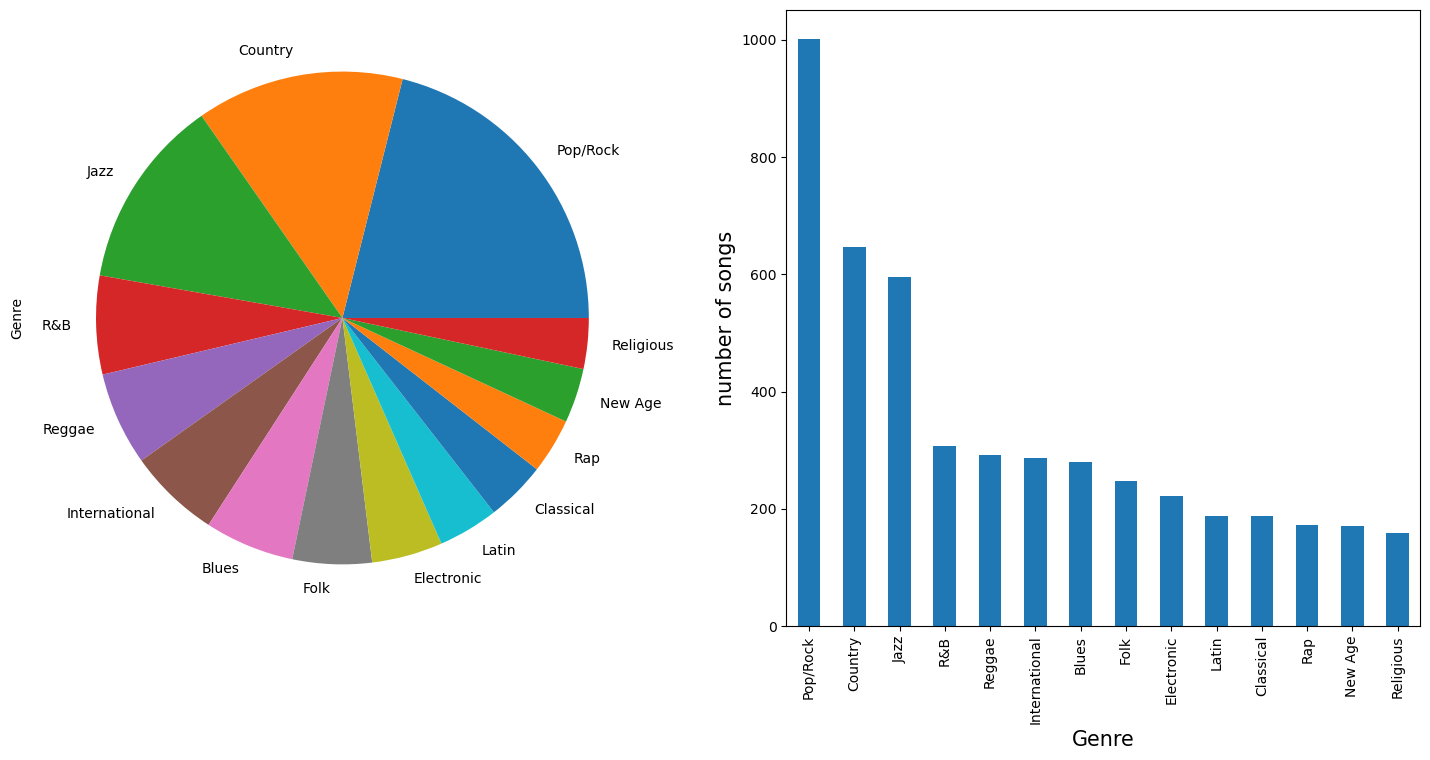

In [20]:
fig, ax = plt.subplots(1,2, figsize=(18,8))
frequent_genres.plot(kind='pie',ax=ax[0])
frequent_genres.plot(kind='bar',ax=ax[1])
plt.ylabel("number of songs",fontsize=15)
plt.xlabel('Genre',fontsize=15)

3.1741468715480634


<AxesSubplot:xlabel='Genre', ylabel='Average covers'>

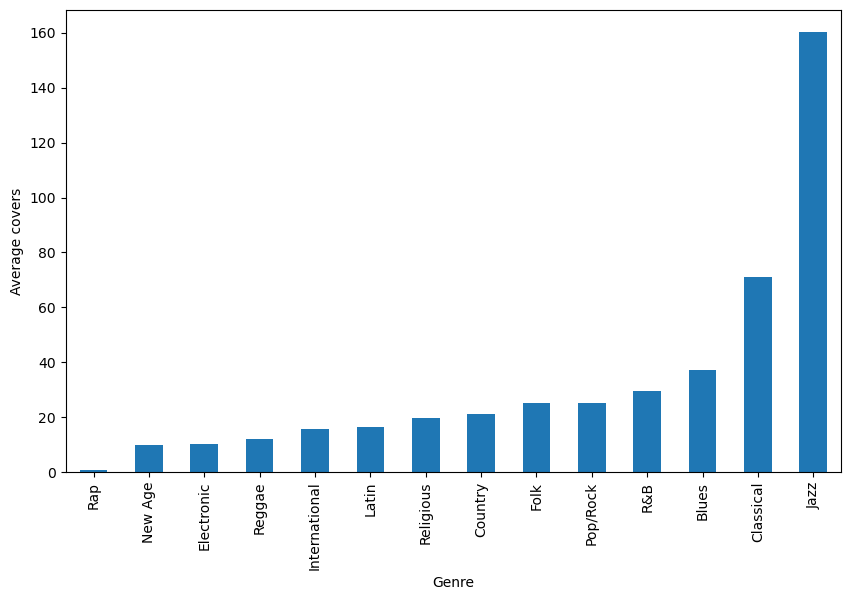

In [21]:
#we would like to remove all songs that do not belong to the top genres
top_genre_list=frequent_genres.to_dict()
top_genre_list=list(top_genre_list.keys())
top_genre_list
print(newdf['Rating'].mean())
newdf = newdf[newdf['Genre'].isin(top_genre_list)]
newdf =newdf.reset_index(drop=True)

cg_avg=newdf.groupby(['Genre'])['Covers'].mean()

#edited from stackoverflow.com
plt.rcParams["figure.figsize"] = (10,6)
cg_avg=cg_avg.sort_values(ascending=True)
plt.ylabel("Average covers")
cg_avg.plot(kind='bar')


(2.5, 3.75)

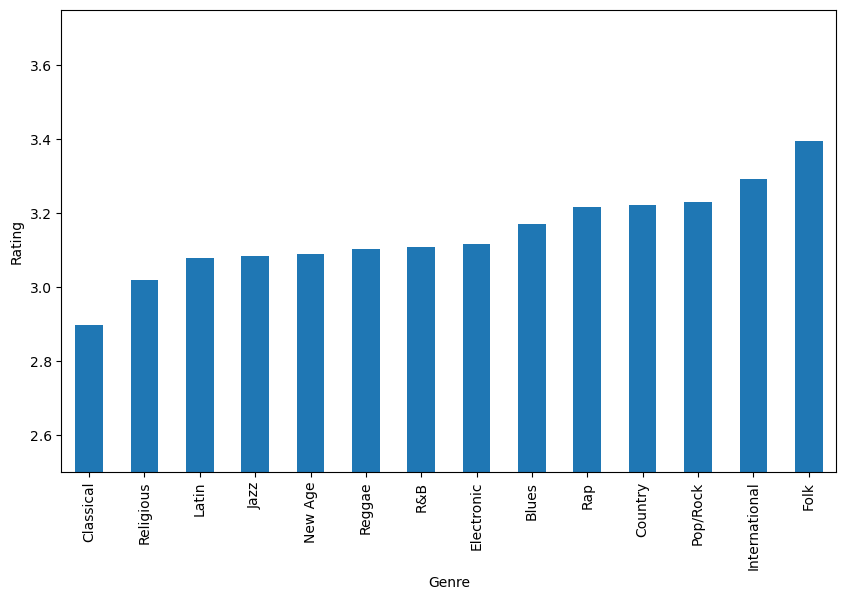

In [22]:
gr_avg=newdf.groupby(['Genre'])['Rating'].mean()
gr_avg=gr_avg.sort_values(ascending=True)
gr_avg.plot(kind='bar')
plt.ylabel("Rating")
plt.xlabel("Genre")
plt.ylim(2.5,3.75)

[Text(0, 0, 'Pop/Rock'),
 Text(1, 0, 'Electronic'),
 Text(2, 0, 'Classical'),
 Text(3, 0, 'Blues'),
 Text(4, 0, 'Jazz'),
 Text(5, 0, 'R&B'),
 Text(6, 0, 'Country'),
 Text(7, 0, 'Folk'),
 Text(8, 0, 'Latin'),
 Text(9, 0, 'Rap'),
 Text(10, 0, 'Religious'),
 Text(11, 0, 'International'),
 Text(12, 0, 'New Age'),
 Text(13, 0, 'Reggae')]

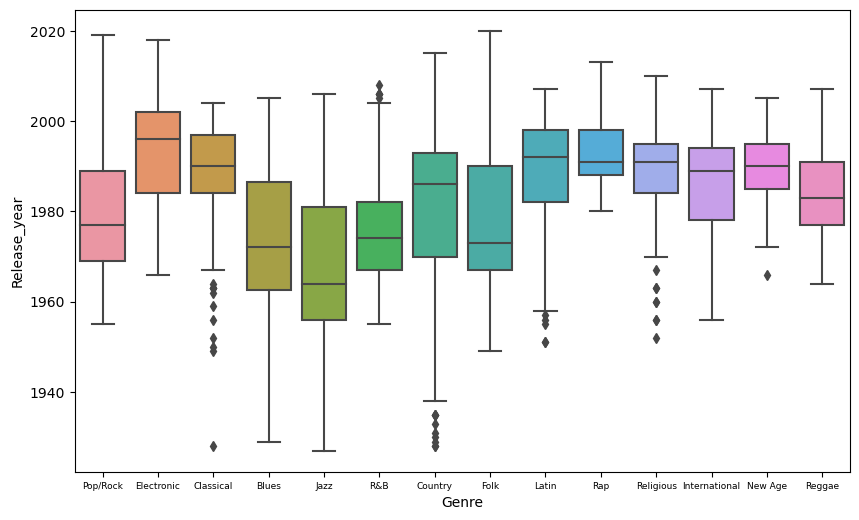

In [23]:
ax=sns.boxplot(newdf.Genre,newdf.Release_year)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=6.5)

In [24]:
newdf.Rating.loc[newdf["Rating"]<3.7]=0
newdf.Rating.loc[newdf["Rating"]>=3.7]=1
newdf

,Song,Artist,Genre,Composed,Release_year,Different albums,Covers,Rating
0,Cris d'Aveugle,Diamanda Galás,Pop/Rock,Diamanda Galás,1986,2,0,0.0
1,All Is Full of Love,Björk,Electronic,Björk,2005,1,15,0.0
2,Some Clouds Do,Fred Frith,Pop/Rock,Fred Frith,1983,2,0,0.0
3,Some Clouds Don't,Fred Frith,Pop/Rock,Fred Frith,1983,2,0,0.0
4,Same Old Me,Fred Frith,Pop/Rock,Fred Frith,1983,2,0,0.0
...,...,...,...,...,...,...,...,...
4746,Who Will the Next Fool Be?,"Bobby ""Blue"" Bland",Blues,Charlie Rich,1991,10,32,1.0
4747,Call on Me,"Bobby ""Blue"" Bland",R&B,Al Bell,1963,9,1,0.0
4748,Two Steps From the Blues,"Bobby ""Blue"" Bland",Blues,John Riley Brown,1961,12,14,0.0
4749,Members Only,"Bobby ""Blue"" Bland",Blues,Larry Addison,1985,6,13,0.0


In [25]:
#transfer to numeric values
newdf=newdf.apply(lambda x:pd.factorize(x, sort=True)[0])
newdf

,Song,Artist,Genre,Composed,Release_year,Different albums,Covers,Rating
0,841,193,9,401,58,2,0,0
1,137,71,3,167,77,1,15,0
2,3627,252,9,547,55,2,0,0
3,3628,252,9,547,55,2,0,0
4,3400,252,9,547,55,2,0,0
...,...,...,...,...,...,...,...,...
4746,4361,80,0,272,63,10,32,1
4747,599,80,10,14,35,9,1,0
4748,4130,80,0,822,33,12,14,0
4749,2585,80,0,926,57,6,13,0


In [26]:
def split_to_train_and_test(dataset, label_column, test_ratio, rand_state):
    
    X = dataset.drop(columns=label_column)
    
    y = dataset[label_column]
    
    
    X_train,X_test = train_test_split(X,train_size=1-test_ratio ,random_state=rand_state)
    
    Y_train,Y_test = train_test_split(y, train_size= 1-test_ratio ,random_state=rand_state)
    
    return X_train, X_test, Y_train, Y_test

In [27]:
test_rate=0.2
rand_state=229
X_train, X_test, y_train, y_test = split_to_train_and_test(newdf,'Rating',test_rate,rand_state)

In [28]:
def KNN(X_train, y_train,X_test,y_test):

    knn =KNeighborsClassifier()
    parameters = {'n_neighbors':range(3,25,2) }#we wand k to be an odd number
    clf = GridSearchCV(knn, parameters,scoring=make_scorer(metrics.accuracy_score, greater_is_better=True))
    knn_trained=clf.fit(X_train, y_train)
    y_pred_train=knn_trained.predict(X_train)
    y_pred=knn_trained.predict(X_test)

    print("Accuracy on training data=",knn_trained.best_score_,", best K is:",knn_trained.best_params_['n_neighbors'])
    print("Accuracy on test data=",metrics.accuracy_score(y_true = y_test, y_pred = y_pred))


In [29]:
KNN(X_train, y_train,X_test,y_test)


Accuracy on training data= 0.8565789473684211 , best K is: 17
Accuracy on test data= 0.8391167192429022


In [30]:
def decision_tree(X_train, y_train,X_test,y_test):
    parameters = {'max_depth':[3,4,5],"min_samples_split":[5,6,7,10,12,15]}
    dtree = tree.DecisionTreeClassifier()
    clf = GridSearchCV(dtree, parameters, scoring=make_scorer(metrics.accuracy_score, greater_is_better=True))
    trained_tree=clf.fit(X_train, y_train)
    y_pred_train=trained_tree.predict(X_train)
    y_pred=trained_tree.predict(X_test)
    print("Accuracy on training data=",clf.best_score_,", best params are:",clf.best_params_)
    print("Accuracy on test data=",metrics.accuracy_score(y_true = y_test, y_pred = y_pred))
 

In [31]:
decision_tree(X_train, y_train,X_test,y_test)

Accuracy on training data= 0.8528947368421053 , best params are: {'max_depth': 3, 'min_samples_split': 5}
Accuracy on test data= 0.8422712933753943


In [32]:
def NaiveBayes(X_train,y_train,X_test,y_test):

    gnb = GaussianNB()

    gnb_trained=gnb.fit(X_train,y_train)
    y_pred_train = gnb_trained.predict(X_train)
    y_pred = gnb_trained.predict(X_test)
    print('Accuracy on train data= ', metrics.accuracy_score(y_true = y_train, y_pred = y_pred_train))
    print('Accuracy on test data= ', metrics.accuracy_score(y_true = y_test, y_pred = y_pred))

In [33]:
NaiveBayes(X_train, y_train,X_test,y_test)

Accuracy on train data=  0.7636842105263157
Accuracy on test data=  0.7549947423764458


In [34]:
def random_forest(X_train, y_train,X_test,y_test):
    parameters = {'n_estimators':range(11,110,10)}
    forest = RandomForestClassifier()
    clf = GridSearchCV(forest, parameters, scoring=make_scorer(metrics.accuracy_score, greater_is_better=True))
    trained_forest=clf.fit(X_train, y_train)
    y_pred_train=trained_forest.predict(X_train)
    y_pred=trained_forest.predict(X_test)
    print("Accuracy on training data=",trained_forest.best_score_,"best params are:",trained_forest.best_params_)
    print("Accuracy on test data=",metrics.accuracy_score(y_true = y_test, y_pred = y_pred))


In [35]:
random_forest(X_train, y_train,X_test,y_test)


Accuracy on training data= 0.8621052631578948 best params are: {'n_estimators': 41}
Accuracy on test data= 0.8517350157728707


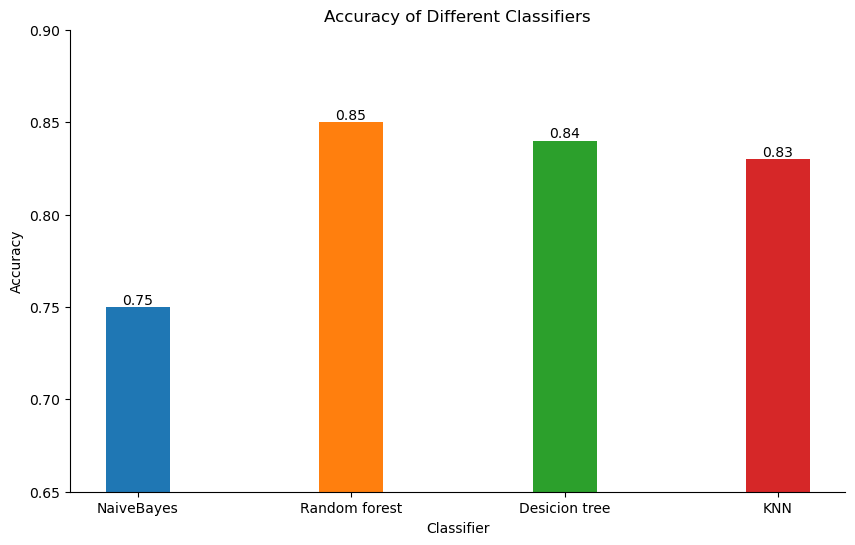

In [36]:

ac = {"name":["NaiveBayes","Random forest","Desicion tree","KNN"], "accuracy":[0.75,0.85,0.84,0.83]}
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]

fig, ax = plt.subplots()

rects = ax.bar(ac['name'], ac['accuracy'], width=0.3, color=colors)


ax.set_xlabel('Classifier')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy of Different Classifiers')

ax.set_ylim([0.65, 0.9])

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add value labels to each bar
for rect in rects:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height, round(height, 4), ha='center', va='bottom')

plt.show()